In [4]:
import pandas as pd
import os

# Correct path to the file
file_path = "../data/raw/Inpatient__Emergency_Department__and_Outpatient_Visits_for_Respiratory_Illnesses_20250514.csv"
df = pd.read_csv(file_path)
df.head()

,mmwr_week,week,week_start,week_end,season,data_source,essence_category,respiratory_category,visit_type,demographic_category,demographic_group,percent,current_week_ending
0,201710,10,03/05/2017,03/11/2017,2016-2017,ESSENCE,CDC COVID-Specific DD v1,COVID-19,ED Visits,Age Group,Age Unknown,0.0,03/08/2025
1,202446,46,11/10/2024,11/16/2024,2024-2025,ESSENCE,Influenza-like Illness,ILI,ED Visits,Age Group,Age Unknown,0.0,11/16/2024
2,201935,35,08/25/2019,08/31/2019,2018-2019,ESSENCE,CDC COVID-Specific DD v1,COVID-19,ED Visits,ALL,ALL,0.0,08/30/2025
3,202447,47,11/17/2024,11/23/2024,2024-2025,ESSENCE,Influenza-like Illness,ILI,ED Visits,Age Group,Age Unknown,0.0,11/23/2024
4,202447,47,11/17/2024,11/23/2024,2024-2025,ESSENCE,CDC Broad Acute Respiratory DD v1,Broad Acute Respiratory,ED Visits,Age Group,Age Unknown,0.2,11/23/2024


In [7]:
# Convert date columns to datetime format
df['week_start'] = pd.to_datetime(df['week_start'], errors='coerce')
df['week_end'] = pd.to_datetime(df['week_end'], errors='coerce')
df['current_week_ending'] = pd.to_datetime(df['current_week_ending'], errors='coerce')

# Check the changes
df[['week_start', 'week_end', 'current_week_ending']].dtypes

week_start             datetime64[ns]
week_end               datetime64[ns]
current_week_ending    datetime64[ns]
dtype: object

In [8]:
#Remove rows with missing or zero percent
# Before cleaning
print("Before cleaning:", df.shape)

# Remove rows where 'percent' is NaN or zero
df = df[df['percent'].notna() & (df['percent'] > 0)]

# After cleaning
print("After cleaning:", df.shape)


Before cleaning: (51849, 13)
After cleaning: (26133, 13)


In [9]:
# List of text columns to clean
text_columns = [
    'season', 'data_source', 'essence_category',
    'respiratory_category', 'visit_type',
    'demographic_category', 'demographic_group'
]

# Strip whitespace and standardize to title case
for col in text_columns:
    df[col] = df[col].astype(str).str.strip().str.title()

# Optional: Preview cleaned values
df[text_columns].head()

,season,data_source,essence_category,respiratory_category,visit_type,demographic_category,demographic_group
4,2024-2025,Essence,Cdc Broad Acute Respiratory Dd V1,Broad Acute Respiratory,Ed Visits,Age Group,Age Unknown
26,2024-2025,Essence,Influenza-Like Illness,Ili,Ed Visits,Race/Ethnicity,Asian Non-Hispanic
36,2024-2025,Essence,Cdc Covid-Specific Dd V1,Covid-19,Admissions,Race/Ethnicity,Asian Non-Hispanic
44,2024-2025,Essence,Cdc Broad Acute Respiratory Dd V1,Broad Acute Respiratory,Ed Visits,Race/Ethnicity,Asian Non-Hispanic
57,2024-2025,Essence,Influenza-Like Illness,Ili,Admissions,Race/Ethnicity,Asian Non-Hispanic


In [12]:
# Check total duplicate rows (all columns match)
total_duplicates = df.duplicated().sum()
print("Total completely duplicated rows:", total_duplicates)

# Check for partial duplicates by key columns (ignoring 'percent')
partial_duplicates = df.duplicated(subset=[
    'mmwr_week', 'week', 'week_start', 'week_end', 'season',
    'data_source', 'essence_category', 'respiratory_category',
    'visit_type', 'demographic_category', 'demographic_group',
    'current_week_ending'
]).sum()
print("Partial duplicates ignoring 'percent':", partial_duplicates)

Total completely duplicated rows: 0
Partial duplicates ignoring 'percent': 0


In [13]:
# Drop partial duplicates (based on identifying columns)
df.drop_duplicates(subset=[
    'mmwr_week', 'week', 'week_start', 'week_end', 'season',
    'data_source', 'essence_category', 'respiratory_category',
    'visit_type', 'demographic_category', 'demographic_group',
    'current_week_ending'
], keep='first', inplace=True)

print("Shape after dropping partial duplicates:", df.shape)

Shape after dropping partial duplicates: (26133, 13)


In [15]:
# Import os to handle directories
import os

# Define output directory and file name
output_dir = "../data/cleaned"
output_file = "Inpatient_Respiratory_Visits_Cleaned.csv"
output_path = os.path.join(output_dir, output_file)

# Create directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Save the cleaned DataFrame to CSV
df.to_csv(output_path, index=False)

print(f"Cleaned data saved to: {output_path}")

Cleaned data saved to: ../data/cleaned/Inpatient_Respiratory_Visits_Cleaned.csv


In [16]:
# Group by week, visit type, respiratory category, and demographic group
agg_df = df.groupby(
    ['current_week_ending', 'visit_type', 'respiratory_category', 'demographic_group']
)['percent'].mean().reset_index()

# Save the aggregated data
agg_path = "../data/cleaned/Inpatient_Trend_Aggregated.csv"
agg_df.to_csv(agg_path, index=False)

print(f"📊 Aggregated summary saved to: {agg_path}")

📊 Aggregated summary saved to: ../data/cleaned/Inpatient_Trend_Aggregated.csv


<Figure size 5000x5000 with 0 Axes>

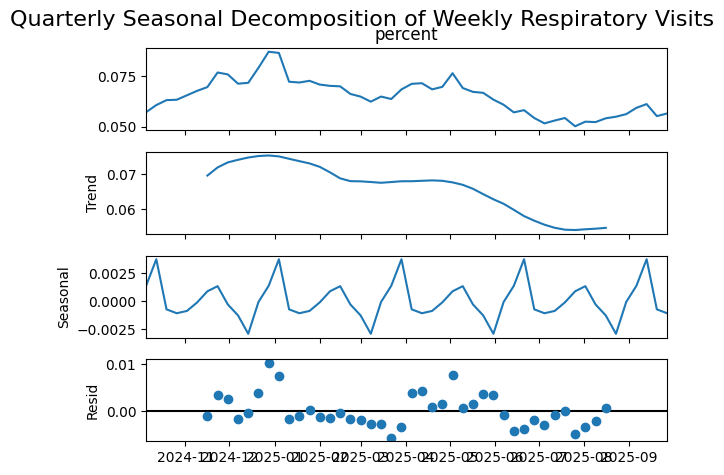

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("../data/cleaned/Inpatient_Respiratory_Visits_Cleaned.csv")

# Weekly aggregation
weekly_df = df.groupby('current_week_ending')['percent'].mean().reset_index()
weekly_df['current_week_ending'] = pd.to_datetime(weekly_df['current_week_ending'])
weekly_df.set_index('current_week_ending', inplace=True)
weekly_df = weekly_df.asfreq('W-SAT')
weekly_df['percent'] = weekly_df['percent'].interpolate(method='linear')

# Decomposition using period=12 (quarterly)
result = seasonal_decompose(weekly_df['percent'], model='additive', period=12)

# Plot results
plt.figure(figsize=(50,50))
result.plot()
plt.suptitle("Quarterly Seasonal Decomposition of Weekly Respiratory Visits", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()